In [2]:
from google.colab import drive
drive.mount("/content/drive")
#!cd /content/drive/My Drive/
#drive.mount('/content/drive/My Drive/')

Mounted at /content/drive


In [5]:
from time import time
import math
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Input, Embedding, LSTM, Dense, Dot, Reshape, Lambda, GRU, concatenate, Conv1D, GlobalMaxPool1D, Dropout
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.layers import Layer
from keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from nltk.corpus import stopwords
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
from gensim.models import word2vec
from gensim.models import KeyedVectors
import numpy as np
import itertools
import re
import scipy.spatial.distance as dist
%matplotlib inline

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
wv = KeyedVectors.load_word2vec_format('./drive/MyDrive/Colab Notebooks/dataset/GoogleNews-vectors-negative300.bin', binary=True)

In [111]:
def get_vector(text):
    sum_vec = np.zeros(300)
    count = 0
    for w in text:
        if w in wv:
            sum_vec += wv[w]
            count += 1
    if count == 0:
        count = 1
    return sum_vec / count

def sum_qd(q, d):
    sum = 0
    for i in range(len(q)):
        sum += q[i] * d[i]
    return sum

def root_square_sum(v):
    sum = 0
    for i in range(len(v)):
        sum += v[i] * v[i]
    root = math.sqrt(sum)
    return root

def cos_sim(v1, v2):
    if (np.linalg.norm(v1) * np.linalg.norm(v2)) == 0:
        print("no word")
        return 0
    a = sum_qd(v1, v2)
    b = root_square_sum(v1) * root_square_sum(v2)
    return a/b

def manhattan_distance(v1, v2):
    return dist.cityblock(v1, v2)/100
    #return math.exp(-dist.cityblock(v1, v2)/8)

In [89]:
# File paths
TRAIN_CSV = './drive/MyDrive/Colab Notebooks/dataset/questions.csv'
# Load training set
train_df = pd.read_csv(TRAIN_CSV, encoding="cp932")
input_left = train_df['question1'].values
input_right = train_df['question2'].values

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [102]:
len(input_right)

404351

In [103]:
output_list = []
for i in range(len(input_left)):
    doc_w = []
    doc_w.append(str(input_left[i]).split())
    doc_w.append(str(input_right[i]).split())
    for i in range(2):
        words = []
        for w in doc_w[i]:
            w = w.replace("'s", '')
            w = re.sub(re.compile("[!-/:-@[-`{-~]"), '', w)
            if w not in stop_words:
                if w != '':
                    words.append(w)
        doc_w[i] = words
    v1 = get_vector(doc_w[0])
    v2 = get_vector(doc_w[1])
    output_list.append(manhattan_distance(v1, v2))
print("Done.")

Done.


In [ ]:
output_list

In [116]:
output_list = []
with open("./drive/MyDrive/Colab Notebooks/test_data/STS.input.images.txt", "r", encoding="shift_jis") as f:
    for line in f:
        line = line.lower()
        line = line.rstrip().split("\t")
        doc_w = []
        doc_w.append(line[0].split())
        doc_w.append(line[1].split())
        for i in range(2):
            words = []
            #line2 = []
            for w in doc_w[i]:
                w = w.replace("'s", '')
                w = re.sub(re.compile("[!-/:-@[-`{-~]"), '', w)
            #    line2.append(w)
            #stemmer = PorterStemmer()
            #line2 = list(map(stemmer.stem, line2))
            #wnl = WordNetLemmatizer()
            #line2 = list(map(wnl.lemmatize, line2))
            #for w in line2:
                if w not in stop_words:
                    if w != '':
                        words.append(w)
            #stemmer = PorterStemmer()
            #words = list(map(stemmer.stem, words))
            #wnl = WordNetLemmatizer()
            #words = list(map(wnl.lemmatize, words))
            doc_w[i] = words
        v1 = get_vector(doc_w[0])
        v2 = get_vector(doc_w[1])
        output_list.append(cos_sim(v1, v2))

In [117]:
#書き込み
#出力ファイルに文字コードをUTF-8にして出力
with open("./drive/MyDrive/Colab Notebooks/test_data/STS.output_gensim2.images.txt", "w", encoding="utf-8") as fw:
    for i in range(len(output_list)):
        print(output_list[i], file=fw)

In [24]:
a = np.array(output_list)
print(a.max())

1.0


In [118]:
output = []
with open("./drive/MyDrive/Colab Notebooks/test_data/STS.output_gensim2.images.txt", "r", encoding="utf-8") as fr:
    for line in fr:
        output.append(float(line))

def gs_label(file):
    labels = []
    with open(file, "r", encoding="utf-8") as f:
        for line in f:
            line = line.rstrip().split()
            line = line[0]
            labels.append(float(line))
    return labels
y_ts = gs_label("./drive/MyDrive/Colab Notebooks/test_data/STS.gs.images.txt")

# リストをps.Seriesに変換
s1=pd.Series(y_ts)
s2=pd.Series(output)

# pandasを使用してPearson's rを計算
res=s1.corr(s2)   # numpy.float64 に格納される

# 結果
print(res)

0.8013475803441613


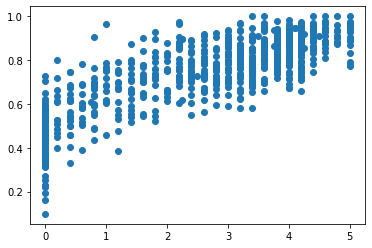

In [119]:
plt.scatter(s1, s2)
plt.show()